# Введение в нейросети для CV на pytorch

![](images/mnist.jpeg)

Классическая задача распознавания рукописных цифр на основе набора данных [MNIST](http://yann.lecun.com/exdb/mnist/)

## Постановка задачи

- 60_000 изображений с цифрами
- Отцентрированы
- Черно-белые
- Размер 28x28 пикселя

# Простейшая однослойная нейросеть

![](images/one_layer.png)

Изображение цифры, размером 28x28 уплощается в вектор размера 784 пикселей, который подается на вход однослойной нейросети. Каждый нейрон по отдельности проивзодит взвешенную сумму всех входных сигналов, добавляет некоторый bias-порог и пропускает результат через некоторую функцию активации.

![](images/perceptron_schematic.png)

### Функция перцептрона

Результат вычисления - взвешенная сумма входов нейрона.

На выходе - функция активации, создающая нелинейность.

$$Y = g(X.W + b) $$

$$sigmoid(z_n) = \frac{1}{1 + e^{z_n}} $$

$$softmax(z_n) = \frac{e^{z_n}}{||{e^z}||} $$

### Функци активации

![](images/activation_functions.png)

Для классификаии обычно используют функцию активации softmax. Она возвращает значения от 0 до 1 - т.е. вероятности принадлежности классу.

Формула в матричном виде $$Y = g(X.W + b) $$

Зачем? Чтобы работать с Группой картинок (Батчем). Тем более GPU отлично работает с матрицами.

![](images/eval_single_layer.png)

![](images/softmax-regression-vectorequation.png)

### Тренировка сети

Чтобы оценить, на сколько нейросеть ошиблась в предсказании, нужна формула расстояния от y предсказанного до y ожидаемого (как в разметке).

Используем формулу кросс-энтропии.

$$H_{y'}(y) = - \sum{y'_i log(y_i)}$$

y - оригинальный  вектор

y' - предсказанный  вектор

#### Бинарная кросс-энтропия

$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i | X_i) + (1-y_i) \cdot log (1-P(y_i | X_i)) ]$$

![](images/cross_entropy.png)

## Практика 0

- знакомство с Pytorch

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision

print(torch.__version__)

1.7.0


In [2]:
torch.cuda.is_available()

True

In [3]:
x = torch.arange(0,16).view(4,4).type(torch.FloatTensor)

print("X :\n%s" % x)
print("X.shape : %s\n" % (x.shape,))
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n%s" % torch.matmul(x, x.transpose(1, 0)))  # short: x.mm(x.t())
print("mean over cols :\n%s" % torch.mean(x, dim=-1))
print("cumsum of cols :\n%s" % torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
X.shape : torch.Size([4, 4])

add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


Нарисуем прикольный график.

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$

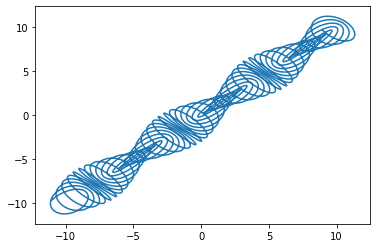

In [4]:
t = torch.linspace(-10, 10, steps=10000)

# compute x(t) and y(t) as defined above
x =  t-1.5*torch.cos(15*t)
y =  t-1.5*torch.sin(16*t)

plt.plot(x.numpy(), y.numpy())

Pytorch - это не только numpy на gpu! Но и фреймворк для описания и обучения нейросетей!

Опишем нейросеть 

$$P(y_i | X_i) = \sigma(W \cdot X_i + b) ={ 1 \over {1+e^{- [W \cdot X_i + b]}} }$$

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

INPUT_SIZE = 4 # на входе 4 сигнала
OUTPUT_SIZE = 1
model = nn.Sequential()
model.add_module('first', nn.Linear(INPUT_SIZE, OUTPUT_SIZE))
model.add_module('softmax', nn.Sigmoid())
model

Sequential(
  (first): Linear(in_features=4, out_features=1, bias=True)
  (softmax): Sigmoid()
)

In [6]:
model.first.weight

Parameter containing:
tensor([[ 0.0459,  0.0241, -0.3308, -0.1219]], requires_grad=True)

In [7]:
x = torch.rand(4)
print('Input', x)
y = model.forward(x)
print('Ouput', y)

Input tensor([0.7138, 0.4646, 0.2473, 0.8912])
Ouput tensor([0.5175], grad_fn=<SigmoidBackward>)


# Практика 1

- загрузить dataset
- описать структуру сети
- запустить обучение

In [8]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

trainset = torchvision.datasets.MNIST(root='data/', train=True,download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='data/', train=False,download=True, transform=transform)

print(trainset.classes)
print(trainset.data.shape)
print(testset.data.shape)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [9]:
trainset[0][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

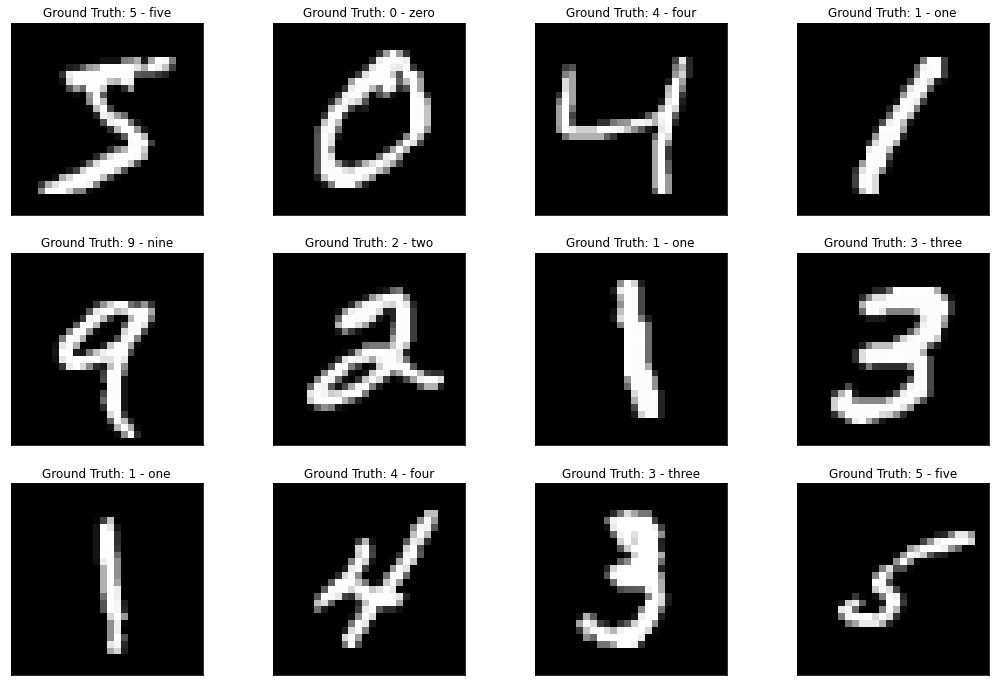

In [10]:
def get_img(tensor):
    tensor = tensor / 2 + 0.5
    npimg = tensor.numpy()
    return npimg[0]

fig = plt.figure(figsize=(18,12))
N_ROWS = 3
N_COLS = 4
for i in range(N_ROWS*N_COLS):
    img = get_img(trainset[i][0])
    label = trainset.classes[trainset[i][1]]

    plt.subplot(N_ROWS,N_COLS,i+1)
#     plt.tight_layout()
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(label))
    plt.xticks([])
    plt.yticks([])

In [11]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=8)

test_loader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=8)

In [12]:
# возвращает батч из объектов
batch = next(iter(train_loader))
batch

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

In [13]:
batch[0].shape

torch.Size([256, 1, 28, 28])

In [14]:
batch[0].view(-1, 28*28).shape

torch.Size([256, 784])

In [15]:
# специальный модуль для уплощения входа.
# у нас картинки двухмерные, а нейросеть работает с плоским массивом
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [16]:
import torch.optim as optim
import time
from IPython.display import clear_output

def train(model, criterion, optimizer):
    model.cuda()
    criterion.cuda()

    train_loss = []
    val_accuracy = []
    
    val_accuracy_mean = []
    loss_mean = []
    
    num_epochs = 10

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = time.time()

        # Обучение модели на тренировочных данных
        model.train()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.cuda()) # пропускаем батч через нейросеть

            loss = criterion(outputs, labels.cuda()) # вычисляем ошибку предсказания
            loss.backward() # вычисляем градиенты методом обратного распространения ошибок
            optimizer.step() # выполняем шаг оптимизации на основе вычисленных градиентов

            train_loss.append(loss.item())


        # Тестирование модели на отложенной выборке
        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            for batch_idx, (inputs, labels) in enumerate(test_loader):
                outputs = model(inputs.cuda())
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted.cpu() == labels).sum().item()
                val_accuracy.append(correct/total)

        loss_epoch = np.mean(train_loss[-len(train_loader):])
        acc_epoch = np.mean(val_accuracy[-len(test_loader):]) * 100

        loss_mean.append(loss_epoch)
        val_accuracy_mean.append(acc_epoch)

        clear_output()
        
        fig = plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        plt.plot(np.array(val_accuracy_mean), label='val accuracy')
        plt.legend(loc='best')
        plt.grid()
        
        plt.subplot(1,2,2)
        plt.plot(np.array(loss_mean), label='train loss')
        plt.legend(loc='best')
        plt.grid()
        
        plt.show()

        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(loss_epoch))
        print("  validation accuracy: \t\t\t{:.2f} %".format(acc_epoch))

    print('Best accuracy = {:.2f}. Epoch = {}'.format(np.max(val_accuracy_mean), np.argmax(val_accuracy_mean)))
    print('Finished Training')

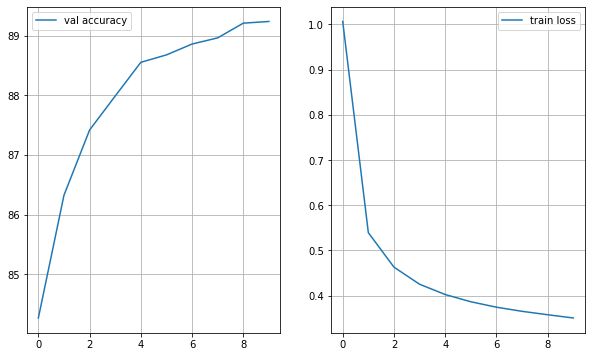

Epoch 10 of 10 took 3.931s
  training loss (in-iteration): 	0.350619
  validation accuracy: 			89.24 %
Best accuracy = 89.24. Epoch = 9
Finished Training


In [17]:
dummy_model = nn.Sequential()
dummy_model.add_module('flatten', Flatten())
dummy_model.add_module('layer_1', nn.Linear(28*28, 10))
# мнимый слой с активацией :)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dummy_model.parameters(), lr=0.001, momentum=0.9)

train(dummy_model, criterion, optimizer)

# 0.89

![](images/tiny_success.jpg)

![](images/go_deeper.jpg)

# Практика 2

- Многослойная нейросеть
- проблема переобучения
- регуляризация

# Многослойная сеть

![](images/deep_neural_network.png)

![](images/deep_mnist.png)

$$sigmoid(z_n) = \frac{1}{1 + e^{z_n}} $$

![](images/sigmoid.png)

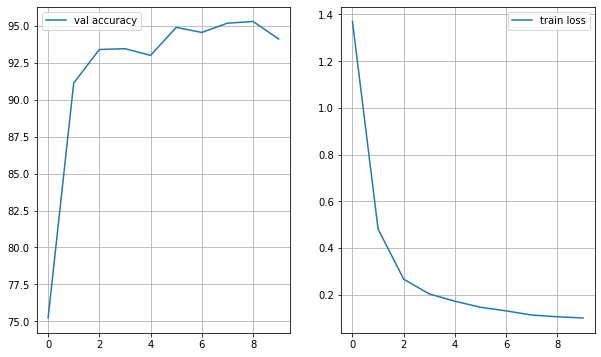

Epoch 10 of 10 took 3.755s
  training loss (in-iteration): 	0.099954
  validation accuracy: 			94.12 %
Best accuracy = 95.30. Epoch = 8
Finished Training


In [18]:
deep_model = nn.Sequential(
    Flatten(),
    
    nn.Linear(28*28, 200),
    nn.Sigmoid(),
    
    nn.Linear(200, 100),
    nn.Sigmoid(),
    
    nn.Linear(100, 60),
    nn.Sigmoid(),
    
    nn.Linear(60, 30),
    nn.Sigmoid(),
    
    nn.Linear(30, 10),
)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_model.parameters(), lr=0.003)

train(deep_model, criterion, optimizer)

# 0.95???

![](images/fry.png)

### sigmoid + softmax + 5 layers
- Качество классификации: 0.94
- Медленно сходится
- Есть резкие перепады при обучении
- Нужна другая функция активации

# Relu = Rectified Linear Unit

![](images/relu.png)

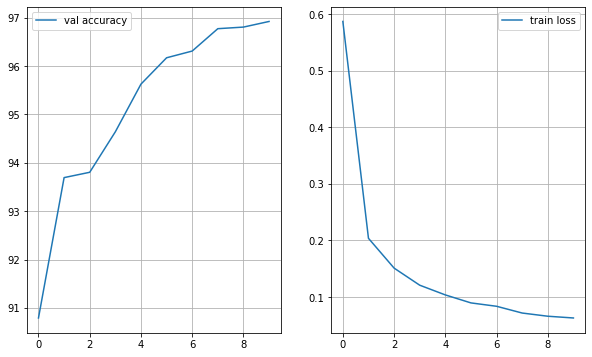

Epoch 10 of 10 took 3.835s
  training loss (in-iteration): 	0.063049
  validation accuracy: 			96.92 %
Best accuracy = 96.92. Epoch = 9
Finished Training


In [19]:
deep_model = nn.Sequential(
    Flatten(),
    
    nn.Linear(28*28, 200),
    nn.ReLU(),
    
    nn.Linear(200, 100),
    nn.ReLU(),
    
    nn.Linear(100, 60),
    nn.ReLU(),
    
    nn.Linear(60, 30),
    nn.ReLU(),
    
    nn.Linear(30, 10),
)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_model.parameters(), lr=0.003)

train(deep_model, criterion, optimizer)

# 0.97???

![](images/fry.png)

Тут еще про learning rate decay, dropout и прочее

# Свёрточная нейросеть

![](images/common_cnn_design.jpg)

![](images/1.png)

![](images/2.png)

![](images/3.png)

![](images/conv_layers.png)

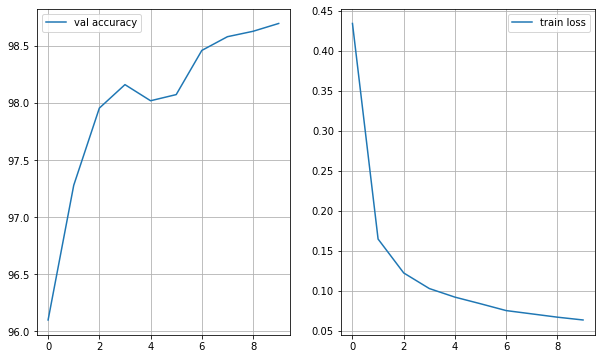

Epoch 10 of 10 took 3.898s
  training loss (in-iteration): 	0.063510
  validation accuracy: 			98.69 %
Best accuracy = 98.69. Epoch = 9
Finished Training


In [20]:
cnn_model = nn.Sequential(
    # Оуе Flatten не нужен!
    
    # 28x28x1
    
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(5, 5), stride=1, padding=2),
    nn.ReLU(),
    
    # 28x28x4
    
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(4, 4), stride=2, padding=1),
    nn.ReLU(),
    
    # 14x14x8
    
    nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(4, 4), stride=2, padding=1),
    nn.ReLU(),
    
    Flatten(), # упс, всё-таки нужен flatten
    nn.Dropout2d(p=0.5), # регуляризация
    
    nn.Linear(7*7*12, 200),
    nn.ReLU(),
    
    nn.Linear(200, 10),
)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.003)

train(cnn_model, criterion, optimizer)

# 99.2

![](images/like_a_boss.jpg)